In [40]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import io
import plotly.express as px

In [3]:
test = pd.read_csv("../../../data/external/Yelp/test.csv")
train = pd.read_csv("../../../data/external/Yelp/train.csv")

In [8]:
train.head()

,text,label
0,"Unfortunately, the frustration of being Dr. Go...",0
1,Been going to Dr. Goldberg for over 10 years. ...,1
2,I don't know what Dr. Goldberg was like before...,0
3,I'm writing this review to give you a heads up...,0
4,All the food is great here. But the best thing...,1


In [11]:
sentences = train['text'].tolist()
labels = train['label'].tolist()

# split into training and validation sets
training_size = int(len(sentences) * 0.8)
validation_size = int(len(sentences) * 0.2)

training_sentences = sentences[0:training_size]
training_labels = labels[0:training_size]

validation_sentences = sentences[training_size:]
validation_labels = labels[training_size:]

# turn into numpy arrays for later use
training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)


In [12]:
# tokenize the data
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"


tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
# fit the tokenizer on the training data
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# fit the tokenizer on the validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [14]:
# build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


2023-01-03 14:22:29.349249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

num_epochs = 30
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(validation_padded, validation_labels_final), verbose=2, callbacks=[early_stopping])

Epoch 1/30
14000/14000 - 34s - loss: 0.2007 - accuracy: 0.9183 - val_loss: 0.1945 - val_accuracy: 0.9209 - 34s/epoch - 2ms/step
Epoch 2/30
14000/14000 - 31s - loss: 0.1967 - accuracy: 0.9201 - val_loss: 0.1964 - val_accuracy: 0.9213 - 31s/epoch - 2ms/step
Epoch 3/30
14000/14000 - 26s - loss: 0.1931 - accuracy: 0.9216 - val_loss: 0.1970 - val_accuracy: 0.9204 - 26s/epoch - 2ms/step
Epoch 4/30
14000/14000 - 26s - loss: 0.1900 - accuracy: 0.9230 - val_loss: 0.1983 - val_accuracy: 0.9209 - 26s/epoch - 2ms/step
Epoch 5/30
14000/14000 - 31s - loss: 0.1868 - accuracy: 0.9245 - val_loss: 0.2014 - val_accuracy: 0.9198 - 31s/epoch - 2ms/step
Epoch 6/30
14000/14000 - 26s - loss: 0.1836 - accuracy: 0.9261 - val_loss: 0.2028 - val_accuracy: 0.9200 - 26s/epoch - 2ms/step
Epoch 7/30
14000/14000 - 27s - loss: 0.1807 - accuracy: 0.9273 - val_loss: 0.2034 - val_accuracy: 0.9185 - 27s/epoch - 2ms/step


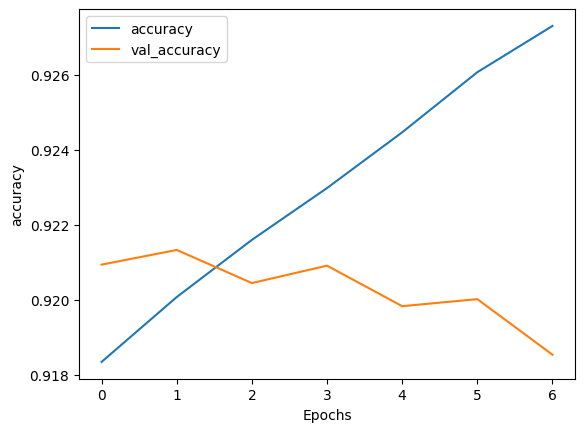

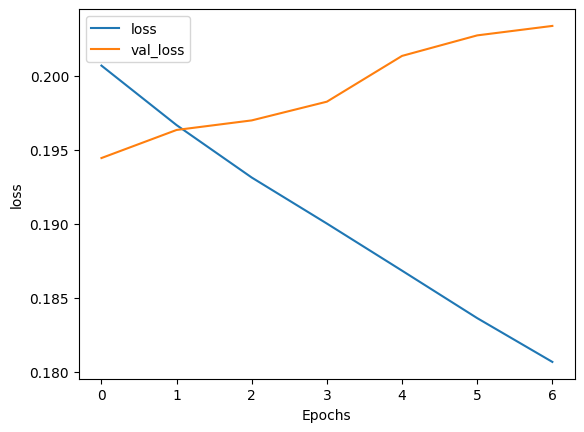

In [21]:
# plot the training and validation loss and accuracy
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


In [22]:
# get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [25]:
# write the weights to a file
out_v = open('../../../data/external/Yelp/vecs.tsv', 'w')
out_m = open('../../../meta.tsv', 'w')
for word_num in range(1, vocab_size):
    word = tokenizer.index_word[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [53]:
# plot the weights of the embedding layer using t-SNE

def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    # plot 3d scatter plot of the embeddings with plotly
    fig = px.scatter_3d(x=low_dim_embs[:,0], y=low_dim_embs[:,1], z=low_dim_embs[:,2], hover_name=labels)
    fig.update_traces(marker=dict(size=2,
                        line=dict(width=2, color='DarkSlateGrey')),
                        selector=dict(mode='markers')
    )

    fig.show()

tsne = TSNE(perplexity=15, n_components=3, init='pca', n_iter=5000)
plot_only = 1000
low_dim_embs = tsne.fit_transform(weights[:plot_only,:])
labels = [tokenizer.index_word[i] for i in range(1, plot_only+1)]
plot_with_labels(low_dim_embs, labels)


In [52]:
plot_only = 5000
# plot with PCA
pca = PCA(n_components=3)
low_dim_embs = pca.fit_transform(weights[:plot_only,:])
labels = [tokenizer.index_word[i] for i in range(1, plot_only+1)]
# print how much of the variance is explained by the first 3 components
print(sum(pca.explained_variance_ratio_))
plot_with_labels(low_dim_embs, labels)


0.9493598267436028
